In [3]:
from pathlib import Path
from models import utils as mutils
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      get_pc_fouriercs_RI_PI_SSOS)
from models import ncsnpp
import time
from utils import fft2_m, ifft2_m, get_mask, get_data_scaler, get_data_inverse_scaler, restore_checkpoint, \
    normalize_complex, root_sum_of_squares
import torch
import torch.nn as nn
import numpy as np
from models.ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import importlib
import argparse


In [4]:
def display_complex_data(data, title):
    data = data.squeeze().numpy()
    num_rows = 3
    num_cols = (data.shape[0] + num_rows - 1) // num_rows  # Calculate number of columns needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    
    for i in range(data.shape[0]):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(np.abs(data[i]), cmap='gray')
        axes[row, col].set_title(f'Channel {i+1}')
        axes[row, col].axis('off')
    plt.suptitle(title)
    plt.show()


In [27]:
def main(N, m, fname, mask_type='gaussian1d', acc_factor=8, center_fraction=0.08):
    ###############################################
    # 1. Configurations
    ###############################################

    filename = f'./samples/multi-coil/{fname}.npy'

    print('Initializing...')
    configs = importlib.import_module("configs.ve.fastmri_knee_320_ncsnpp_continuous")
    config = configs.get_config()
    img_size = config.data.image_size
    batch_size = 1

    # Read data
    img = normalize_complex(torch.from_numpy(np.load(filename).astype(np.complex64)))
    img = img.view(1, 15, 320, 320)
    img = img.to(config.device)

    mask = get_mask(img, img_size, batch_size,
                    type=mask_type,
                    acc_factor=acc_factor,
                    center_fraction=center_fraction)

    #Show MASK 
    mask_np = mask.squeeze().numpy() 

    plt.imshow(np.abs(mask_np[0]), cmap='gray')  # You can specify colormap according to your needs
    plt.title(f"Undersampling mask - {mask_type}")
    plt.axis("off")
    plt.show()

    ckpt_filename = f"./weights/checkpoint_95.pth"
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=N)

    config.training.batch_size = batch_size
    predictor = ReverseDiffusionPredictor
    corrector = LangevinCorrector
    probability_flow = False
    snr = 0.16

    # sigmas = mutils.get_sigmas(config)
    scaler = get_data_scaler(config)
    inverse_scaler = get_data_inverse_scaler(config)

    # create model and load checkpoint
    score_model = mutils.create_model(config)
    ema = ExponentialMovingAverage(score_model.parameters(),
                                   decay=config.model.ema_rate)
    state = dict(step=0, model=score_model, ema=ema)
    state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
    ema.copy_to(score_model.parameters())

    # Specify save directory for saving generated samples
    save_root = Path(f'./results/multi-coil/SSOS')
    save_root.mkdir(parents=True, exist_ok=True)

    irl_types = ['input', 'recon', 'recon_progress', 'label']
    for t in irl_types:
        save_root_f = save_root / t
        save_root_f.mkdir(parents=True, exist_ok=True)
        
    ###############################################
    # 2. Inference
    ###############################################

    pc_fouriercs = get_pc_fouriercs_RI_PI_SSOS(sde,
                                               predictor, corrector,
                                               inverse_scaler,
                                               snr=snr,
                                               n_steps=m,
                                               mask=mask,
                                               probability_flow=probability_flow,
                                               continuous=config.training.continuous,
                                               denoise=True)
    # fft
    kspace = fft2_m(img)

    

    under_kspace = kspace * mask
    under_img = ifft2_m(under_kspace)
    display_complex_data(img, 'Label Images')
    display_complex_data(under_img, 'Undersampled Image - of Each coil')
    #display_complex_data(mask, 'Mask')
    
    # print(f'Beginning inference')
    # tic = time.time()
    # x = pc_fouriercs(score_model, scaler(under_img), y=under_kspace)
    # toc = time.time() - tic
    # print(f'Time took for recon: {toc} secs.')

    ###############################################
    # 3. Saving recon
    ###############################################
    under_img = root_sum_of_squares(under_img, dim=1)
    label = root_sum_of_squares(img, dim=1)
    input = under_img.squeeze().cpu().detach().numpy()
    label = label.squeeze().cpu().detach().numpy()
    mask_sv = mask[0, 0, :, :].squeeze().cpu().detach().numpy()

    save_root = Path(f'./results/multi-coil/SSOS')
    save_root.mkdir(parents=True, exist_ok=True)

    plt.imshow(np.abs(label),cmap='gray')
    # np.save(str(save_root / 'input' / fname) + '.npy', input)
    # np.save(str(save_root / 'input' / (fname + '_mask')) + '.npy', mask_sv)
    # np.save(str(save_root / 'label' / fname) + '.npy', label)
    # plt.imsave(str(save_root / 'input' / fname) + '.png', np.abs(input), cmap='gray')
    # plt.imsave(str(save_root / 'label' / fname) + '.png', np.abs(label), cmap='gray')
    # plt.imsave(str(save_root / 'mask' / fname) + '.png', np.abs(mask), cmap='gray')

    # x = root_sum_of_squares(x, dim=1)
    # recon = x.squeeze().cpu().detach().numpy()
    # np.save(str(save_root / 'recon' / fname) + '.npy', recon)
    # plt.imsave(str(save_root / 'recon' / fname) + '.png', np.abs(recon), cmap='gray')

Initializing...


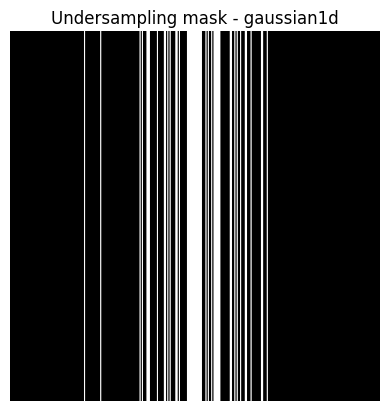

loaded checkpoint dir from ./weights/checkpoint_95.pth


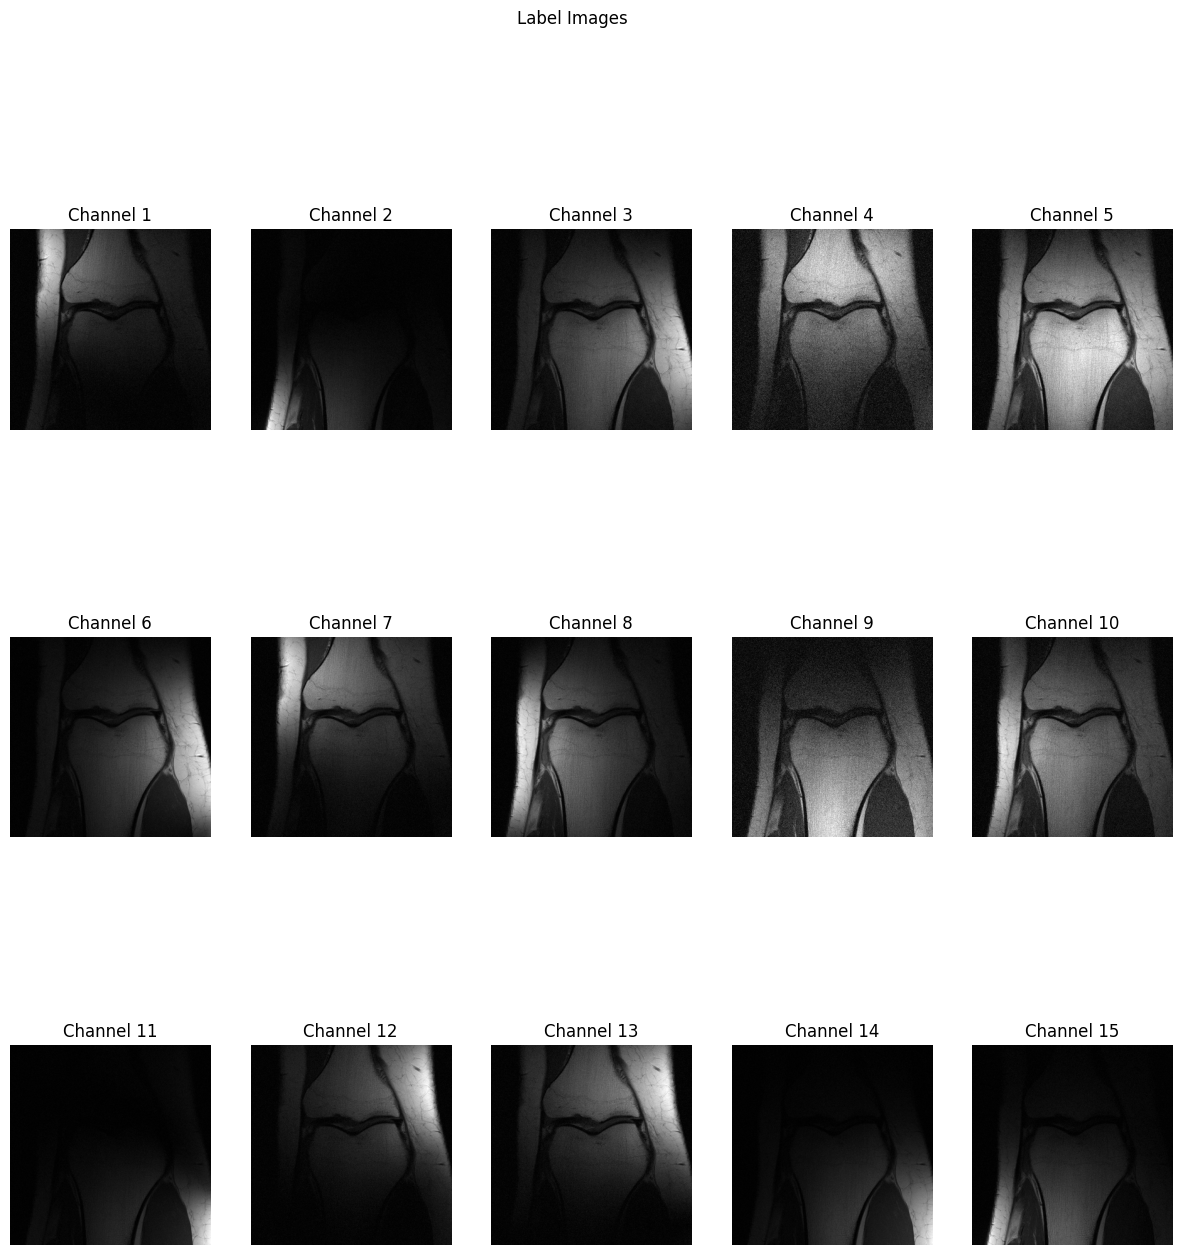

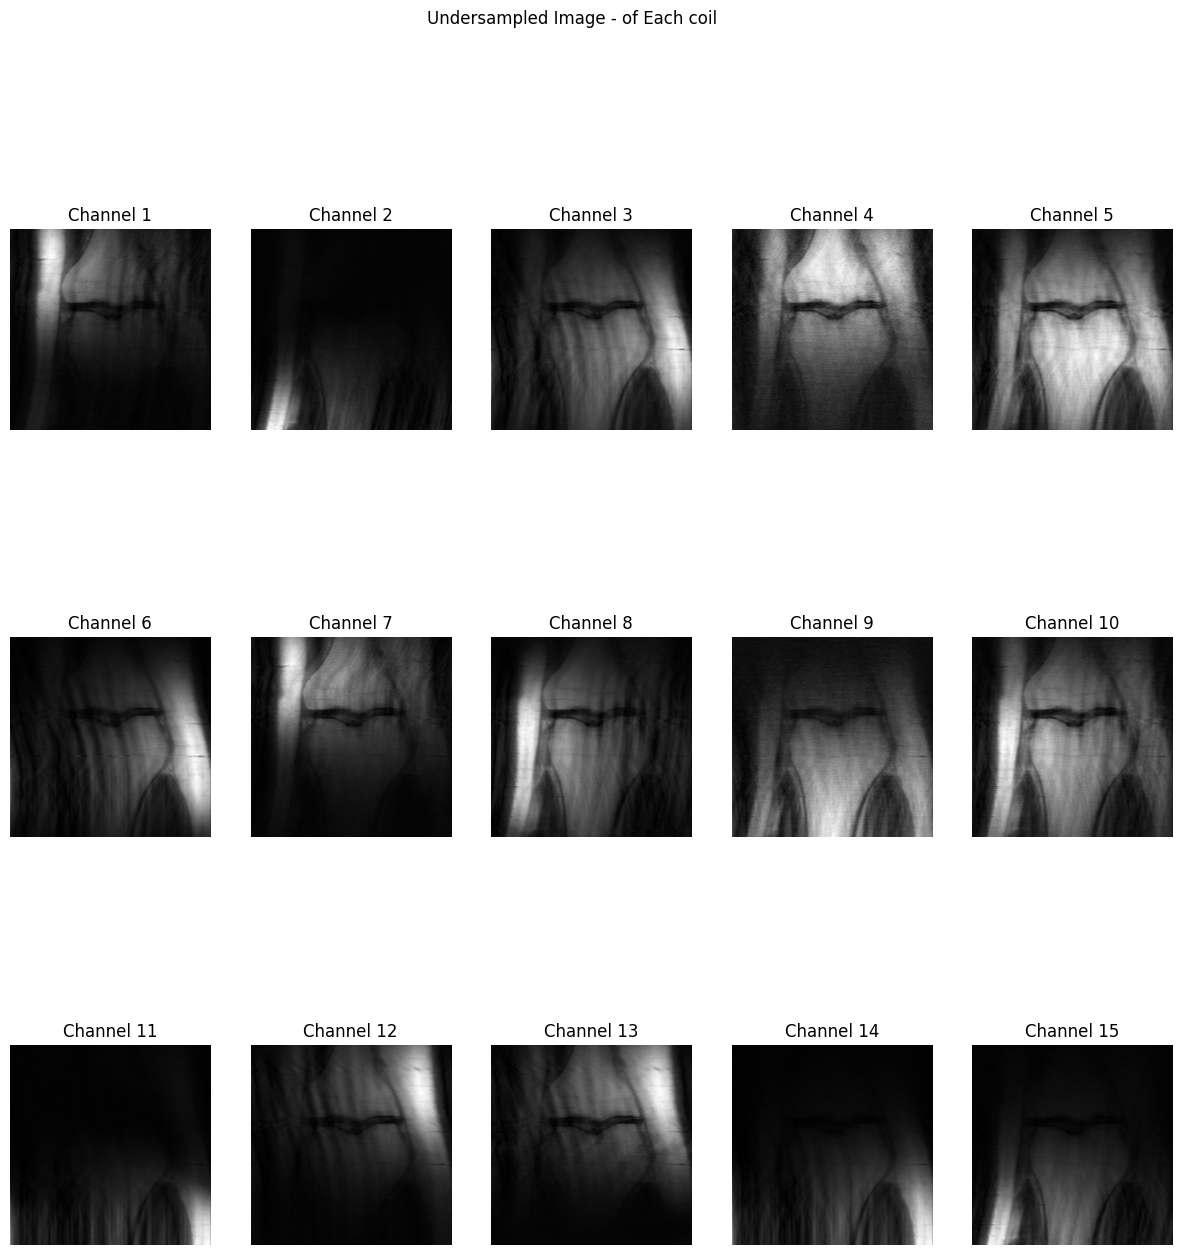

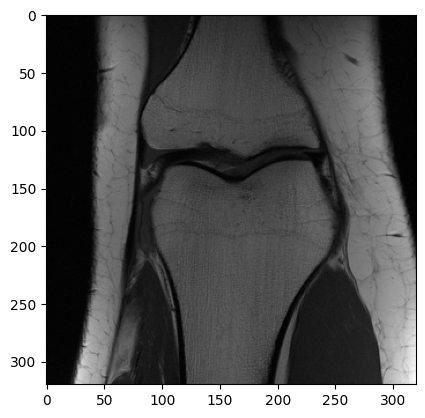

In [28]:
if __name__ == "__main__":
    main(N=220, m=1, mask_type='gaussian1d', acc_factor=8, center_fraction=0.04,  fname="001")